#Import libraries


In [ ]:
import pandas as pd
import numpy as np
import spacy
import random

!pip install -U gensim

from gensim import models
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from gensim.models import LdaMulticore
from gensim.models import CoherenceModel
from gensim.test.utils import datapath

import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
from matplotlib import gridspec
%matplotlib inline

!pip install pyLDAvis

import pyLDAvis
import pyLDAvis.gensim_models

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 24.1 MB 59.9 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.7 MB 4.3 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136898 sha256=2dd2127468de86ce0444a615223605c85daddf567ec208cab8f436378b76e09a
  Stored in directory: /root/.cache/pip/wheels/c9/21/f6/17bcf2667e8a68532ba2fbf6d5c72fdf4c7f7d9abfa4852d2f
Successfully built pyLDAvis


/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/past/builtins/misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping


#Load data




In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/TFM_FINAL/prep_readmes0.csv", 
                 index_col=0)
print(df.shape)
df.head()

(8194, 3)


,readmes,label,Tokens
0,b'# PSIS\n\nData Augmentation for Object Detec...,Computer Vision,"['psis', 'data', 'augment', 'object', 'detect'..."
1,b'# SNIPER / AutoFocus: Efficient Multi-Scale ...,Computer Vision,"['sniper', 'autofocus', 'effici', 'multi', 'sc..."
2,b'# SNIPER: Efficient Multi-Scale Training\n\n...,Computer Vision,"['sniper', 'effici', 'multi', 'scale', 'train'..."
3,b'\xe7\xae\x80\xe4\xbd\x93\xe4\xb8\xad\xe6\x96...,Computer Vision,"['english', 'readm', 'img', 'src', 'href', 'sr..."
4,b'# Model Based RL papers\n\n<h3>Papers List</...,Sequential,"['model', 'base', 'paper', 'paper', 'list', 'w..."


#Create corpus

In [ ]:
df.Tokens = df.Tokens.apply(eval)

In [ ]:
diccionario = Dictionary(df.Tokens)
print(f'Número de tokens: {len(diccionario)}')

Número de tokens: 53990


Finally, we remove the words that are in less than two abstracts and in more than 80% of them since these will introduce more noise than information into our model. Once these words have been filtered we create the final bag of words.

In [ ]:
#Words that are at least in two abstracts and in no more than 80% of abstracts
diccionario.filter_extremes(no_below=2, no_above = 0.8)
print(f'Number de tokens: {len(diccionario)}')

Number de tokens: 23108


In [ ]:
#Doc to bag of words (here we dont take into account bigrams or trigrams)
corpus = [diccionario.doc2bow(abstract) for abstract in df.Tokens]

#Hyperparameter tuning

## First round

In [ ]:
# Topics range
min_topics = 5
max_topics = 15
step_size = 1
topics_range = range(min_topics, max_topics, step_size)
alpha = [0.01, 0.1, 1, 10]
beta_aux = [1, 10, 20]
results = []
for k in topics_range:
  for b in beta_aux:
    for a in alpha:
      lda_model = LdaMulticore(corpus=corpus,
                               id2word=diccionario,
                               num_topics=k,
                               alpha=a,
                               eta=b/k, 
                               random_state=100,
                               chunksize=100,
                               passes=10)
      umass_lda = CoherenceModel(model=lda_model, texts=df.Tokens, dictionary=diccionario, coherence='u_mass')
      npmi_lda = CoherenceModel(model=lda_model, texts=df.Tokens, dictionary=diccionario, coherence='c_npmi')
      results.append([k, a, b/k, b, umass_lda.get_coherence(),npmi_lda.get_coherence()])
evaluation = pd.DataFrame(results, columns=['Number_topics', 'Alpha', 'Beta', 'Num', 'UMASS','NPMI'])

In [ ]:
with open("/content/drive/MyDrive/TFM_FINAL/hptuning_lda_readme0.csv", 'w', encoding = 'utf-8-sig') as f:
  evaluation.to_csv(f)

In [ ]:
evaluation.sort_values('UMASS', ascending=False)

,Number_topics,Alpha,Beta,Num,UMASS,NPMI
19,6,10.00,1.666667,10,-1.048097,0.025637
7,5,10.00,2.000000,10,-1.058650,0.022910
11,5,10.00,4.000000,20,-1.092365,0.026235
3,5,10.00,0.200000,1,-1.122615,0.026828
15,6,10.00,0.166667,1,-1.140521,0.026704
...,...,...,...,...,...,...
81,11,0.10,1.818182,20,-6.651022,-0.035298
21,6,0.10,3.333333,20,-6.928498,-0.085842
20,6,0.01,3.333333,20,-6.959268,-0.092854
117,14,0.10,1.428571,20,-8.594049,-0.082967


In [ ]:
evaluation.sort_values('NPMI', ascending=False)

,Number_topics,Alpha,Beta,Num,UMASS,NPMI
64,10,0.01,1.000000,10,-2.271507,0.048565
40,8,0.01,1.250000,10,-2.027815,0.048233
111,14,10.00,0.071429,1,-1.278992,0.047246
65,10,0.10,1.000000,10,-2.357708,0.044681
86,12,1.00,0.083333,1,-1.301251,0.042687
...,...,...,...,...,...,...
9,5,0.10,4.000000,20,-6.217888,-0.081106
117,14,0.10,1.428571,20,-8.594049,-0.082967
21,6,0.10,3.333333,20,-6.928498,-0.085842
20,6,0.01,3.333333,20,-6.959268,-0.092854


We see that, analogously to what happened with the abstracts, the top models for both metrics have no more than 10 topics and in general alpha ranges between 1 and 0.1 and 10; and beta's numerator between 1 and 10

## Second round

In [ ]:
# Topics range
min_topics = 6
max_topics = 11
step_size = 1
topics_range = range(min_topics, max_topics, step_size)
alpha = [0.1, 1, 5, 10]
beta_aux = [1, 5, 10]
results = []
for k in topics_range:
  for b in beta_aux:
    for a in alpha:
      lda_model = LdaMulticore(corpus=corpus,
                               id2word=diccionario,
                               num_topics=k,
                               alpha=a,
                               eta=b/k, 
                               random_state=100,
                               chunksize=100,
                               passes=10)
      umass_lda = CoherenceModel(model=lda_model, texts=df.Tokens, dictionary=diccionario, coherence='u_mass')
      npmi_lda = CoherenceModel(model=lda_model, texts=df.Tokens, dictionary=diccionario, coherence='c_npmi')
      results.append([k, a, b/k, b, umass_lda.get_coherence(),npmi_lda.get_coherence()])
evaluation_2 = pd.DataFrame(results, columns=['Number_topics', 'Alpha', 'Beta', 'Num', 'UMASS','NPMI'])

In [ ]:
with open("/content/drive/MyDrive/TFM_FINAL/hptuning_lda_readme0_2.csv", 'w', encoding = 'utf-8-sig') as f:
  evaluation_2.to_csv(f)

## Choosing best model

In [ ]:
evaluation = pd.read_csv("/content/drive/MyDrive/TFM_FINAL/hptuning_lda_readme0.csv", 
                          index_col=0)
evaluation_2 = pd.read_csv("/content/drive/MyDrive/TFM_FINAL/hptuning_lda_readme0_2.csv", 
                            index_col=0)

In [ ]:
final_eval = [evaluation, evaluation_2]
final_eval = pd.concat(final_eval)

In [ ]:
final_eval = final_eval.drop_duplicates(subset=['Number_topics','Alpha', 'Num'])
final_eval = final_eval.reset_index(drop=True)

In [ ]:
final_eval.sort_values('UMASS', ascending=False)

,Number_topics,Alpha,Beta,Num,UMASS,NPMI
19,6,10.00,1.666667,10,-1.048097,0.025637
7,5,10.00,2.000000,10,-1.058650,0.022910
11,5,10.00,4.000000,20,-1.092365,0.026235
124,6,10.00,0.833333,5,-1.113679,0.025676
3,5,10.00,0.200000,1,-1.122615,0.026828
...,...,...,...,...,...,...
81,11,0.10,1.818182,20,-6.651022,-0.035298
21,6,0.10,3.333333,20,-6.928498,-0.085842
20,6,0.01,3.333333,20,-6.959268,-0.092854
117,14,0.10,1.428571,20,-8.594049,-0.082967


In [ ]:
final_eval.sort_values('NPMI', ascending=False)

,Number_topics,Alpha,Beta,Num,UMASS,NPMI
64,10,0.01,1.000000,10,-2.271507,0.048565
40,8,0.01,1.250000,10,-2.027815,0.048233
111,14,10.00,0.071429,1,-1.278992,0.047246
65,10,0.10,1.000000,10,-2.357708,0.044681
86,12,1.00,0.083333,1,-1.301251,0.042687
...,...,...,...,...,...,...
9,5,0.10,4.000000,20,-6.217888,-0.081106
117,14,0.10,1.428571,20,-8.594049,-0.082967
21,6,0.10,3.333333,20,-6.928498,-0.085842
20,6,0.01,3.333333,20,-6.959268,-0.092854


We see that based on UMASS the best values are alpha=10 and beta=20/K, however when looking at the highest NPMI values the hyperparameters are more heterogeneous. We'll study first alpha=1 and beta=10/K

In [ ]:
v1 = final_eval.loc[final_eval['Num']==10]
v1 = v1.loc[v1['Alpha']==10]
v2 = final_eval.loc[final_eval['Num']==10]
v2 = v2.loc[v2['Alpha']==0.01]
v3 = final_eval.loc[final_eval['Num']==1]
v3 = v3.loc[v3['Alpha']==10]

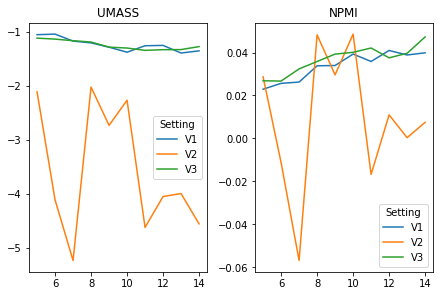

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2,constrained_layout=True)

x = np.arange(5, 15, step=1)
ax1.plot(x,v1.UMASS,label='V1')
ax1.plot(x,v2.UMASS,label='V2')
ax1.plot(x,v3.UMASS,label='V3')
ax1.legend(title='Setting')
ax1.set_title('UMASS')

ax2.plot(x,v1.NPMI,label='V1')
ax2.plot(x,v2.NPMI,label='V2')
ax2.plot(x,v3.NPMI,label='V3')
ax2.legend(title='Setting')
ax2.set_title('NPMI')
#ax2.xticks(x)
plt.show()

We choose the model with k=10 topics, and V3 settings (i.e alpha=10 and beta = 1/k (note that this decission is totally subjective and another researcher may decide that this is not the most suitable model)

In [ ]:
lda_model = LdaMulticore(corpus=corpus,
                         id2word=diccionario,
                         num_topics=10,
                         alpha=10,
                         eta=1/10, 
                         random_state=100,
                         chunksize=100,
                         passes=10)

In [ ]:
umass_lda = CoherenceModel(model=lda_model, texts=df.Tokens, dictionary=diccionario, coherence='u_mass')
npmi_lda = CoherenceModel(model=lda_model, texts=df.Tokens, dictionary=diccionario, coherence='c_npmi')
umass = umass_lda.get_coherence()
npmi = npmi_lda.get_coherence()

In [ ]:
print('UMASS of final model:', umass)
print('NPMI of final model:', npmi)

UMASS of final model: -1.3513831537261793
NPMI of final model: 0.036712916495056216


# aux functions

In [ ]:
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()
    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        if len(row) == 1:
          top = row[0][0]
          prop_topic = round(row[0][1],4)
          choices = ['High', 'Medium', 'Low']
          conditions = [prop_topic>=0.66, (prop_topic<0.66) & (prop_topic>=0.33),
                        prop_topic<0.33]
          conf_1 = np.select(conditions,choices)
          sent_topics_df = sent_topics_df.append(pd.Series([top,prop_topic,conf_1,np.nan,np.nan,np.nan]),ignore_index=True)
        else:
          top_1 = row[0][0]
          prop_topic_1 = round(row[0][1],4)
          choices = ['High', 'Medium', 'Low']
          conditions = [prop_topic_1>=0.66, (prop_topic_1<0.66) & (prop_topic_1>=0.33),
                        prop_topic_1<0.33]
          conf_1 = np.select(conditions,choices)
          top_2 = row[1][0]
          prop_topic_2 = round(row[1][1],4)
          choices = ['High', 'Medium', 'Low']
          conditions = [prop_topic_2>=0.66, (prop_topic_2<0.66) & (prop_topic_2>=0.33),
                        prop_topic_2<0.33]
          conf_2 = np.select(conditions,choices)
          sent_topics_df = sent_topics_df.append(pd.Series([top_1,prop_topic_1,conf_1,top_2,prop_topic_2,conf_2]),ignore_index=True)
    # Add original text to the end of the output
    contents = pd.Series(texts)
    labels = df['label']
    sent_topics_df = pd.concat([sent_topics_df, contents,labels], axis=1)

    return(sent_topics_df)

# Topic modeling vs human classification

In [ ]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=df['Tokens'])

In [ ]:
# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic_1', 'Topic_1_Perc_Contrib',
                               'Confidence_1', 'Dominant_Topic_2', 'Topic_2_Perc_Contrib',
                               'Confidence_2','Text','Labels']

In [ ]:
for i in range(len(df_dominant_topic)):
  df_dominant_topic.loc[i,'Confidence_1'] = str(df_dominant_topic.loc[i,'Confidence_1'])
  df_dominant_topic.loc[i,'Confidence_2'] = str(df_dominant_topic.loc[i,'Confidence_2'])

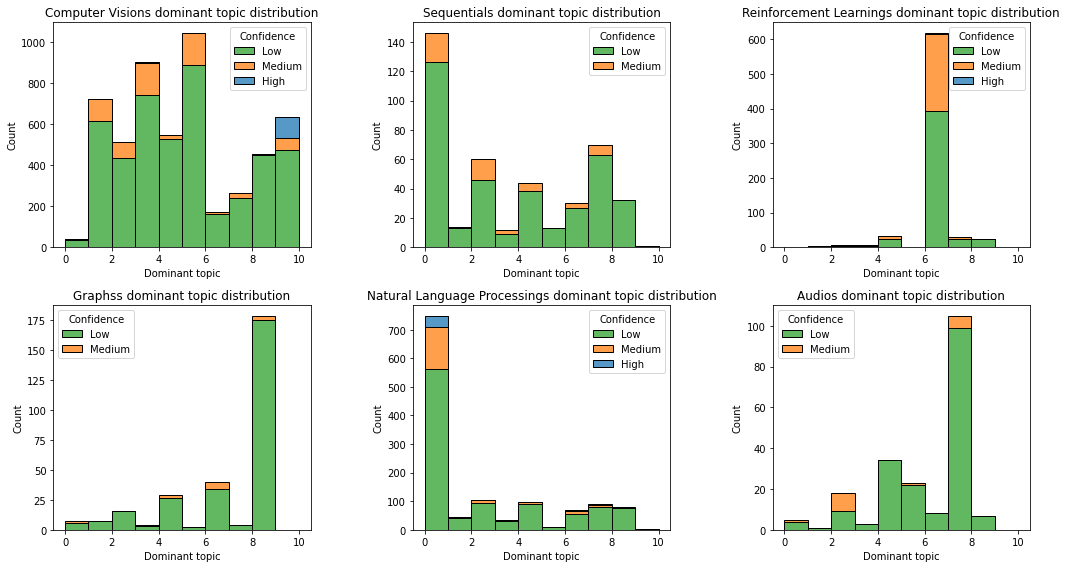

In [ ]:
plt.figure(figsize=(15,8), tight_layout=True)
labels = df['label'].unique()
i = 1
for lab in labels:
  plt.subplot(2,3,i)
  i = i + 1
  df2 = df_dominant_topic[df_dominant_topic['Labels']==lab]
  ax = sns.histplot(data=df2,x='Dominant_Topic_1', hue="Confidence_1",
                    multiple='stack', binwidth=1,binrange=(0,10), 
                    hue_order=['High', 'Medium','Low'], legend=False)
  ax.set(xlabel='Dominant topic', ylabel='Count')
  plt.legend(title='Confidence', labels=['Low', 'Medium', 'High'])
  plt.title(f'{lab}s dominant topic distribution')
plt.show()

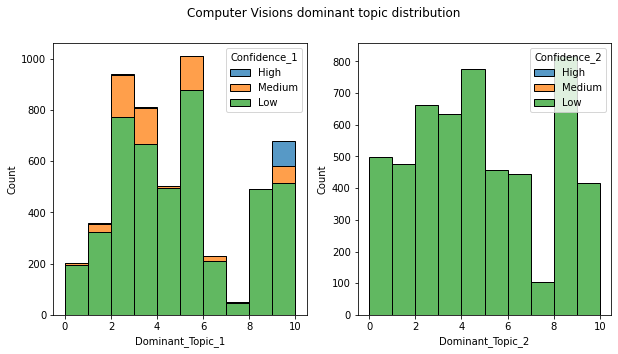

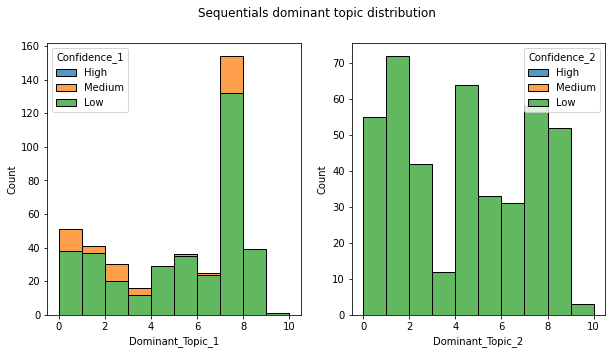

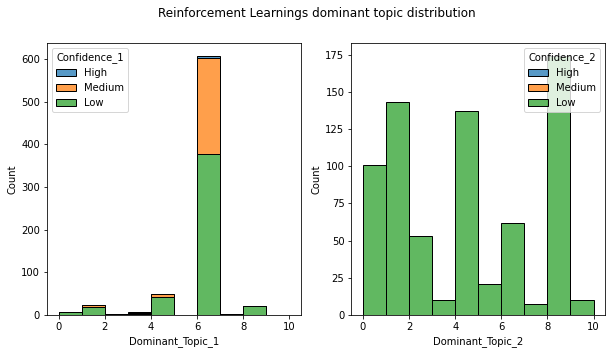

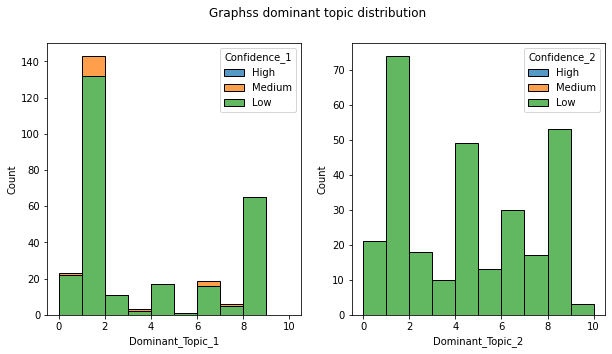

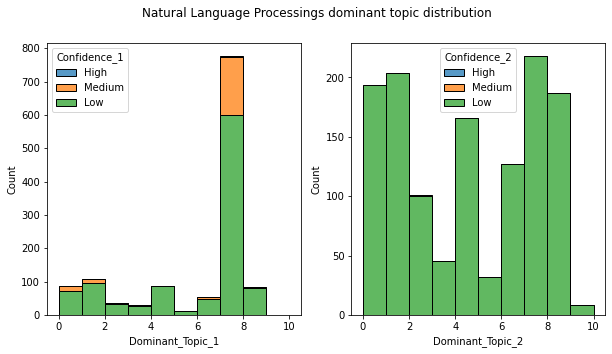

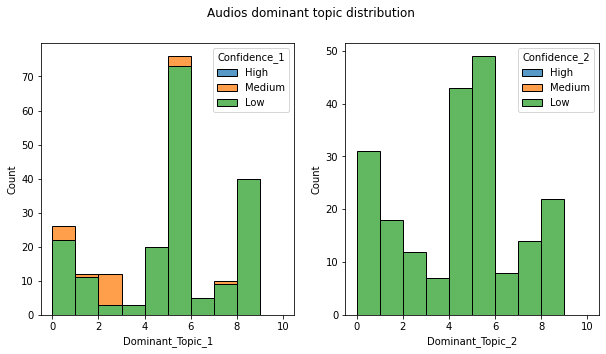

In [ ]:
#First and second
for lab in labels:
  df3 = df_dominant_topic[df_dominant_topic['Labels']==lab]
  fig = plt.figure(figsize=(10,5))
  fig.suptitle(f'{lab}s dominant topic distribution')
  gs = gridspec.GridSpec(nrows=1, 
                       ncols=2)
  ax1 = fig.add_subplot(gs[0, 0])
  sns.histplot(data=df3,x='Dominant_Topic_1', hue="Confidence_1", 
               multiple="stack", binwidth=1,binrange=(0,10), 
               hue_order=['High', 'Medium', 'Low'])
  ax2 = fig.add_subplot(gs[0, 1])
  sns.histplot(data=df3,x='Dominant_Topic_2', hue="Confidence_2", 
               multiple="stack", binwidth=1,binrange=(0,10), 
               hue_order=['High', 'Medium', 'Low'])
  plt.show()

In [ ]:
lda_model.show_topics()

[(0,
  '0.059*"model" + 0.029*"text" + 0.027*"task" + 0.020*"transform" + 0.020*"use" + 0.020*"languag" + 0.017*"pre" + 0.016*"sequenc" + 0.015*"train" + 0.014*"base"'),
 (1,
  '0.049*"data" + 0.024*"imag" + 0.022*"use" + 0.021*"model" + 0.016*"predict" + 0.016*"dataset" + 0.011*"set" + 0.010*"label" + 0.010*"featur" + 0.009*"one"'),
 (2,
  '0.027*"layer" + 0.025*"attent" + 0.023*"input" + 0.022*"network" + 0.021*"convolut" + 0.017*"size" + 0.015*"output" + 0.015*"transform" + 0.012*"architectur" + 0.012*"decod"'),
 (3,
  '0.045*"model" + 0.025*"href" + 0.018*"arxiv" + 0.016*"pleas" + 0.016*"imagenet" + 0.014*"resnet" + 0.014*"link" + 0.013*"segment" + 0.012*"vit" + 0.012*"vision"'),
 (4,
  '0.103*"train" + 0.045*"model" + 0.033*"dataset" + 0.031*"run" + 0.028*"file" + 0.028*"use" + 0.021*"set" + 0.021*"evalu" + 0.020*"test" + 0.018*"download"'),
 (5,
  '0.064*"generat" + 0.046*"imag" + 0.026*"sampl" + 0.019*"train" + 0.018*"dataset" + 0.017*"png" + 0.015*"use" + 0.014*"paper" + 0.013*

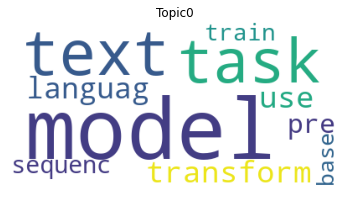

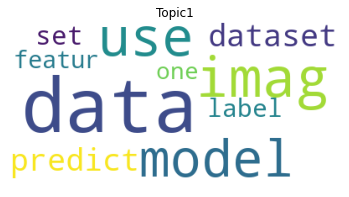

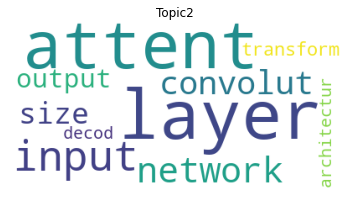

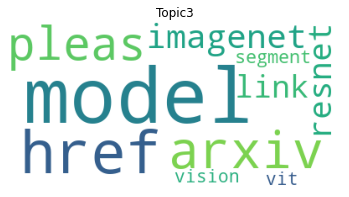

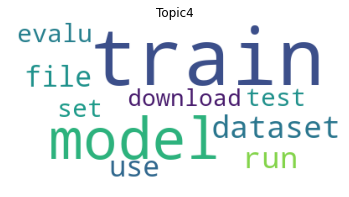

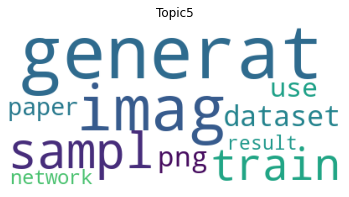

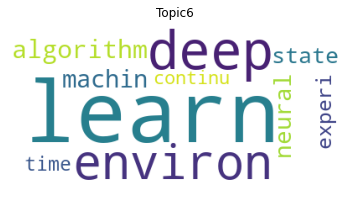

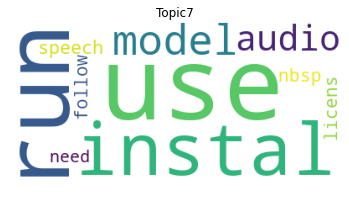

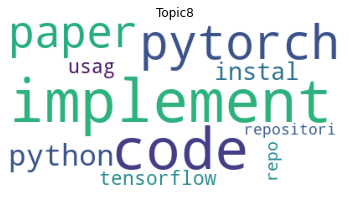

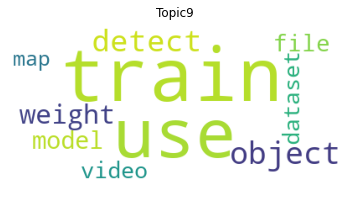

In [ ]:
topics = lda_model.print_topics(num_words=10, num_topics=10)
for i in range(0,10):
  plt.figure()
  plt.imshow(WordCloud(background_color='white').fit_words(dict(lda_model.show_topic(i,10))))
  plt.axis('off')
  plt.title('Topic' + str(i))
  plt.show()

In [ ]:
lda_display = pyLDAvis.gensim_models.prepare(lda_model, corpus, diccionario, sort_topics=False)
pyLDAvis.display(lda_display)

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)
